# Intro

- This uses lazy polars less than normal, just so we can show you intermediate results. Lazy mode should be your default

In [1]:
from pathlib import Path
import json
import glob
from datetime import datetime, time, date
import math

import requests
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import pyarrow.compute as pc


def extract_city_name(df: pl.LazyFrame) -> pl.LazyFrame:
    """
    Chicago, IL -> Chicago for OriginCityName and DestCityName
    """
    cols = ["OriginCityName", "DestCityName"]
    return df.with_columns(pl.col(cols).str.split(",").arr.get(0))


def time_col_expr(col: str) -> pl.Expr:
    col_expr = pl.col(col)
    return (
        pl.when(col_expr == "2400")
        .then("0000")
        .otherwise(col_expr)
        .str.strptime(pl.Time, "%H%M", strict=True)
        .alias(col)
    )


def time_to_datetime(df: pl.LazyFrame, columns: list[str]) -> pl.LazyFrame:
    """
    Combine all time items into datetimes.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    """
    date_val = pl.col("FlightDate").dt.epoch("us")
    new_cols = [
        (date_val + time_col_expr(col).to_physical() // 1000)
        .cast(pl.Datetime)
        .alias(col)
        for col in columns
    ]
    return df.with_columns(new_cols)


sns.set_style("ticks")
pd.options.display.max_rows = 5
# States are broken into networks. The networks have a list of ids, each representing a station.
# We will take that list of ids and pass them as query parameters to the URL we built up ealier.
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# IEM has Iowa AWOS sites in its own labeled network
networks = ["AWOS"] + [f"{state}_ASOS" for state in states]
data_dir = Path("data")


In [2]:
data_dir.mkdir(exist_ok=True)
dest = data_dir / "flights.csv.zip"

if not dest.exists():
    r = requests.get(
        "https://transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2022_1.zip",
        verify=False,
        stream=True,
    )

    with dest.open("wb") as f:
        for chunk in r.iter_content(chunk_size=102400):
            if chunk:
                f.write(chunk)


In [76]:
zf = zipfile.ZipFile("data/flights.csv.zip")
fp = zf.extract(zf.filelist[0].filename, path="data/")
category_cols = (
    "Dest",
    "Tail_Number",
    "IATA_CODE_Reporting_Airline",
    "CancellationCode",
)
time_cols = ("DepTime", "ArrTime", "CRSArrTime", "CRSDepTime")
dtypes = (
    {col: pl.Categorical for col in category_cols}
    | {"FlightDate": pl.Date}
    | {col: pl.Utf8 for col in time_cols}
)
cols = (
    category_cols
    + time_cols
    + (
        "FlightDate",
        "Flight_Number_Reporting_Airline",
        "OriginCityName",
        "DestCityName",
        "Origin",
        "DepDelay",
    )
)
df = (
    pl.scan_csv(fp, dtypes=dtypes, null_values="")
    .select(cols)
    .pipe(extract_city_name)
    .pipe(time_to_datetime, time_cols)
    .collect()
)


<AxesSubplot: xlabel='DepTime'>

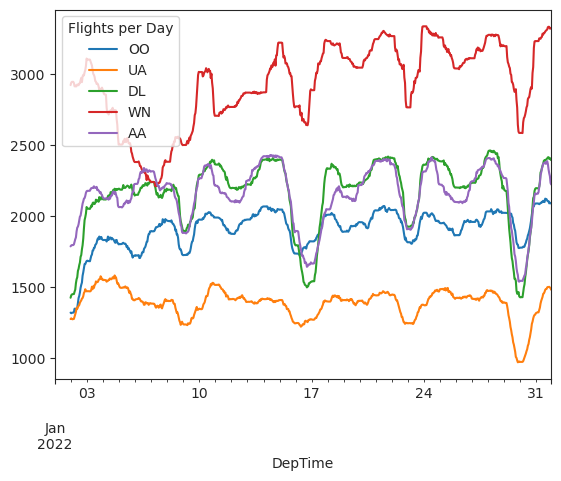

In [4]:
(
    df.to_pandas()
    .dropna(subset=["DepTime", "IATA_CODE_Reporting_Airline"])
    .loc[
        lambda x: x["IATA_CODE_Reporting_Airline"].isin(
            x["IATA_CODE_Reporting_Airline"].value_counts().index[:5]
        )
    ]
    .assign(
        IATA_CODE_Reporting_Airline=lambda x: x[
            "IATA_CODE_Reporting_Airline"
        ].cat.remove_unused_categories()
    )
    .set_index("DepTime")
    # TimeGrouper to resample & groupby at once
    .groupby(["IATA_CODE_Reporting_Airline", pd.Grouper(freq="H")])[
        "Flight_Number_Reporting_Airline"
    ]
    .count()
    .unstack(0)
    .fillna(0)
    .rolling(24)
    .sum()
    .rename_axis("Flights per Day", axis=1)
    .plot()
)


<AxesSubplot: xlabel='DepTime'>

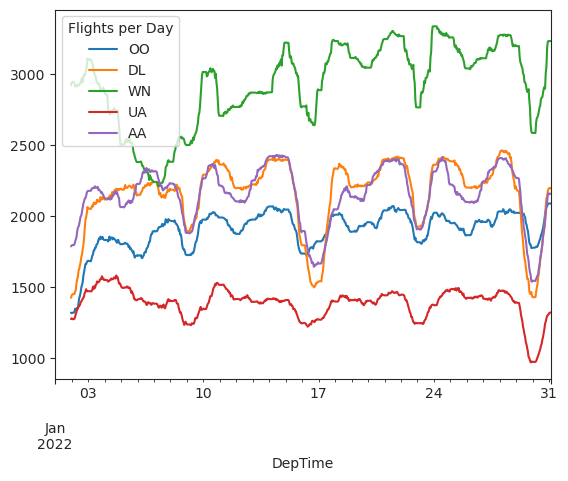

In [5]:
filter_expr = pl.col("IATA_CODE_Reporting_Airline").is_in(
    pl.col("IATA_CODE_Reporting_Airline")
    .value_counts(sort=True)
    .struct.field("IATA_CODE_Reporting_Airline")
    .head(5)
)
(
    df.drop_nulls(subset=["DepTime", "IATA_CODE_Reporting_Airline"])
    .filter(filter_expr)
    .sort("DepTime")
    .groupby_dynamic("DepTime", every="1h", by="IATA_CODE_Reporting_Airline")
    .agg(pl.col("Flight_Number_Reporting_Airline").count())
    .pivot(
        index="DepTime",
        columns="IATA_CODE_Reporting_Airline",
        values="Flight_Number_Reporting_Airline",
    )
    .upsample(time_column="DepTime", every="1h")
    .fill_null(0)
    .sort("DepTime")
    .select([pl.col("DepTime"), pl.col(pl.UInt32).rolling_sum(24)])
    .to_pandas()
    .set_index("DepTime")
    .rename_axis("Flights per Day", axis=1)
    .plot()
)


(-50.0, 50.0)

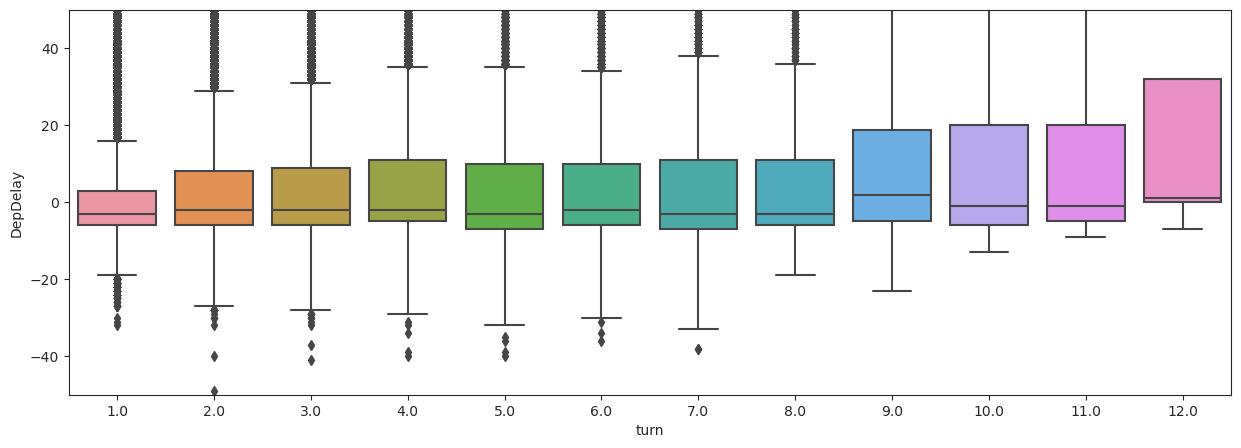

In [6]:
flights = (
    df.select(pl.col(["FlightDate", "Tail_Number", "DepTime", "DepDelay"]))
    .drop_nulls()
    .filter(pl.col("DepDelay") < 500)
    .with_column(
        pl.col("DepTime").rank().over(["FlightDate", "Tail_Number"]).alias("turn")
    )
)

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="turn", y="DepDelay", data=flights.to_pandas(), ax=ax)
ax.set_ylim(-50, 50)


<AxesSubplot: xlabel='hour', ylabel='DepDelay'>

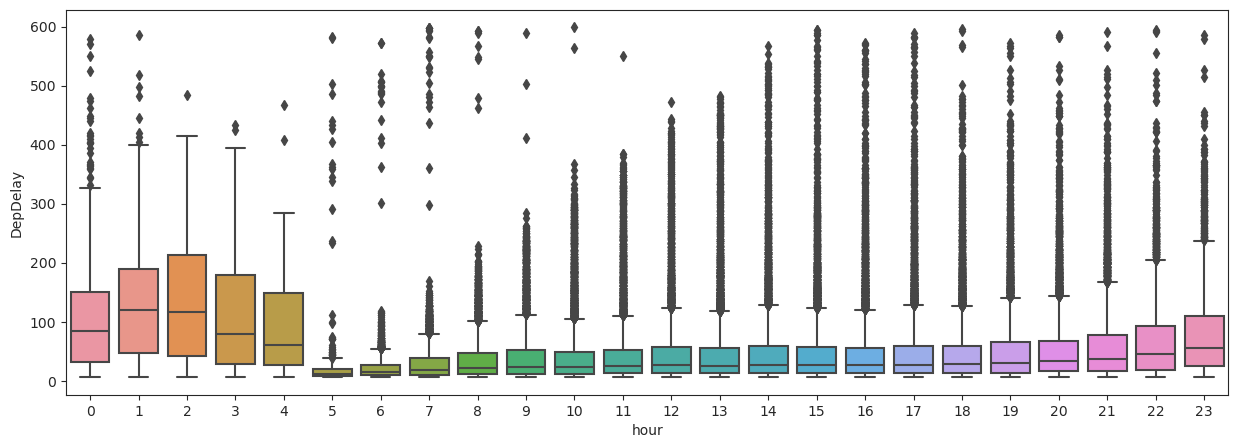

In [7]:
plt.figure(figsize=(15, 5))
(
    df.select(
        pl.col(
            ["FlightDate", "Tail_Number", "DepTime", "DepDelay"],
        )
    )
    .drop_nulls()
    .filter(pl.col("DepDelay").is_between(5, 600))
    .with_column(pl.col("DepTime").dt.hour().alias("hour"))
    .to_pandas()
    .pipe((sns.boxplot, "data"), x="hour", y="DepDelay")
)


# Performance

In [8]:
def gcd_vec(lat1, lng1, lat2, lng2):
    """
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    ϕ1 = np.deg2rad(90 - lat1)
    ϕ2 = np.deg2rad(90 - lat2)

    θ1 = np.deg2rad(lng1)
    θ2 = np.deg2rad(lng2)

    cos = np.sin(ϕ1) * np.sin(ϕ2) * np.cos(θ1 - θ2) + np.cos(ϕ1) * np.cos(ϕ2)
    arc = np.arccos(cos)
    return arc * 6373


def gcd_arrow(lat1, lng1, lat2, lng2):
    """
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    # python2 users will have to use ascii identifiers
    ϕ1 = deg2rad_arrow(pc.subtract(90, lat1))
    ϕ2 = deg2rad_arrow(pc.subtract(90, lat2))

    θ1 = deg2rad_arrow(lng1)
    θ2 = deg2rad_arrow(lng2)

    sine_prod = pc.multiply(pc.sin(ϕ1), pc.sin(ϕ2))
    cosine_diff = pc.cos(pc.subtract(θ1, θ2))
    cos_prod = pc.multiply(pc.cos(ϕ1), pc.cos(ϕ2))
    cos = pc.add(pc.multiply(sine_prod, cosine_diff), cos_prod)
    arc = pc.acos(cos)
    return pc.multiply(arc, 6373)


def deg2rad_pl(degrees: pl.Expr) -> pl.Expr:
    return degrees * math.pi / 180


def deg2rad_arrow(degrees: pl.Expr) -> pl.Expr:
    return pc.multiply(degrees, math.pi / 180)


def gcd_pl(lat1: pl.Expr, lng1: pl.Expr, lat2: pl.Expr, lng2: pl.Expr):
    """
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    # python2 users will have to use ascii identifiers
    ϕ1 = deg2rad_pl(90 - lat1)
    ϕ2 = deg2rad_pl(90 - lat2)

    θ1 = deg2rad_pl(lng1)
    θ2 = deg2rad_pl(lng2)

    cos = ϕ1.sin() * ϕ2.sin() * (θ1 - θ2).cos() + ϕ1.cos() * ϕ2.cos()
    arc = cos.arccos()
    return arc * 6373


In [9]:
airports = pl.scan_csv("data/airports.csv").drop_nulls().unique(subset=["AIRPORT"])
pairs = airports.join(airports, on="AIRPORT", how="cross").filter(
    pl.col("AIRPORT") != pl.col("AIRPORT_right")
)


In [10]:
%%timeit
collected = pairs.collect()
gcd_arrow(collected["LATITUDE"].to_arrow(), collected["LONGITUDE"].to_arrow(), collected["LATITUDE_right"].to_arrow(), collected["LONGITUDE_right"].to_arrow())

5.72 s ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
collected = pairs.collect()
gcd_vec(collected["LATITUDE"].to_numpy(), collected["LONGITUDE"].to_numpy(), collected["LATITUDE_right"].to_numpy(), collected["LONGITUDE_right"].to_numpy())

/tmp/ipykernel_2945/3589155608.py:22: RuntimeWarning: invalid value encountered in arccos
  arc = np.arccos(cos)


5.44 s ± 74.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
pairs.select(gcd_pl(pl.col("LATITUDE"), pl.col("LONGITUDE"), pl.col("LATITUDE_right"), pl.col("LONGITUDE_right"))).collect()

4.37 s ± 80.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
def create_frame(n, n_groups):
    return pd.DataFrame(
        {"name": np.random.randint(0, n_groups, size=n), "value2": np.random.randn(n)}
    )


rand_df_pd = create_frame(50_000_000, 50_000)
rand_df_pl = pl.from_pandas(rand_df_pd)


def pandas_transform(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby("name")["value2"]
    v = df["value2"]
    return (v - g.transform(np.mean)) / g.transform(np.std)


def polars_transform() -> pl.Expr:
    v = pl.col("value2")
    return (v - v.mean().over("name")) / v.std().over("name")


In [55]:
%timeit x=pandas_transform(rand_df_pd)

2.18 s ± 291 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%timeit x=rand_df_pl.select(polars_transform())

2.33 s ± 63.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
import string

s_pd = pd.Series(np.random.choice(list(string.ascii_letters), 100000))
s_pl = pl.from_pandas(s_pd)
print("Pandas string size: {:0.2f} KB".format(s_pd.memory_usage(index=False) / 1000))
print(
    "Pandas categorical size: {:0.2f} KB".format(
        s_pd.astype("category").memory_usage(index=False) / 1000
    )
)
print("Polars string size: {:0.2f} KB".format(s_pl.estimated_size() / 1000))
print(
    "Polars categorical size: {:0.2f} KB".format(
        s_pl.cast(pl.Categorical).estimated_size() / 1000
    )
)


Pandas string size: 800.00 KB
Pandas categorical size: 102.52 KB
Polars string size: 900.01 KB
Polars categorical size: 400.48 KB


# Reshaping and Tidy Data

In [17]:
nba_dir = Path("data/nba/")

column_names = {
    "Date": "date",
    "Visitor/Neutral": "away_team",
    "PTS": "away_points",
    "Home/Neutral": "home_team",
    "PTS.1": "home_points",
}

if not nba_dir.exists():
    nba_dir.mkdir()
    for month in (
        "october",
        "november",
        "december",
        "january",
        "february",
        "march",
        "april",
        "may",
        "june",
    ):
        url = f"http://www.basketball-reference.com/leagues/NBA_2016_games-{month}.html"
        tables = pd.read_html(url)
        raw = (
            pl.from_pandas(tables[0].query("Date != 'Playoffs'"))
            .rename(column_names)
            .select(column_names.values())
        )
        raw.write_csv(nba_dir / f"{month}.csv")

nba_glob = nba_dir / "*.csv"
pl.scan_csv(nba_glob).head().collect()


date,away_team,away_points,home_team,home_points
str,str,i64,str,i64
"""Fri, Apr 1, 20...","""Philadelphia 7...",91,"""Charlotte Horn...",100
"""Fri, Apr 1, 20...","""Dallas Maveric...",98,"""Detroit Piston...",89
"""Fri, Apr 1, 20...","""Brooklyn Nets""",91,"""New York Knick...",105
"""Fri, Apr 1, 20...","""Cleveland Cava...",110,"""Atlanta Hawks""",108
"""Fri, Apr 1, 20...","""Toronto Raptor...",99,"""Memphis Grizzl...",95


In [18]:
games_pd = (
    pl.read_csv(nba_glob)
    .to_pandas()
    .dropna(thresh=4)
    .assign(date=lambda x: pd.to_datetime(x["date"], format="%a, %b %d, %Y"))
    .set_index("date", append=True)
    .rename_axis(["game_id", "date"])
    .sort_index()
)
games_pd.head()


,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2016-04-01,Philadelphia 76ers,91,Charlotte Hornets,100
1,2016-04-01,Dallas Mavericks,98,Detroit Pistons,89
2,2016-04-01,Brooklyn Nets,91,New York Knicks,105
3,2016-04-01,Cleveland Cavaliers,110,Atlanta Hawks,108
4,2016-04-01,Toronto Raptors,99,Memphis Grizzlies,95


In [19]:
games_pl = (
    pl.scan_csv(nba_glob)
    .filter(
        ~pl.fold(
            acc=True,
            f=lambda acc, s: acc & s.is_null(),
            exprs=pl.all(),
        )
    )
    .with_row_count("game_id")
    .with_column(
        pl.col("date").str.strptime(pl.Date, "%a, %b %d, %Y"),
    )
)


In [20]:
games_pl.head().collect()


game_id,date,away_team,away_points,home_team,home_points
u32,date,str,i64,str,i64
0,2016-04-01,"""Philadelphia 7...",91,"""Charlotte Horn...",100
1,2016-04-01,"""Dallas Maveric...",98,"""Detroit Piston...",89
2,2016-04-01,"""Brooklyn Nets""",91,"""New York Knick...",105
3,2016-04-01,"""Cleveland Cava...",110,"""Atlanta Hawks""",108
4,2016-04-01,"""Toronto Raptor...",99,"""Memphis Grizzl...",95


In [21]:
tidy_pl = (
    games_pl.melt(
        id_vars=["game_id", "date"],
        value_vars=["away_team", "home_team"],
        value_name="team",
    )
    .sort("date")
    .with_column(pl.col("date").alias("rest").diff().over("team").dt.days() - 1)
    .drop_nulls("rest")
    .collect()
)


In [22]:
tidy_pd = (
    games_pd.reset_index()
    .melt(
        id_vars=["game_id", "date"],
        value_vars=["away_team", "home_team"],
        value_name="team",
    )
    .assign(
        rest=lambda df: df.sort_values("date").groupby("team")["date"].diff().dt.days
        - 1
    )
    .dropna(subset=["rest"])
)
tidy_pd


,game_id,date,variable,team,rest
0,0,2016-04-01,away_team,Philadelphia 76ers,2.0
1,1,2016-04-01,away_team,Dallas Mavericks,1.0
...,...,...,...,...,...
2630,1314,2015-10-31,home_team,Portland Trail Blazers,0.0
2631,1315,2015-10-31,home_team,Los Angeles Clippers,1.0


In [23]:
by_game_pd = tidy_pd.pivot(
    values="rest", index=["game_id", "date"], columns="variable"
).rename(columns={"away_team": "away_rest", "home_team": "home_rest"})

by_game_pl = tidy_pl.pivot(
    values="rest", index=["game_id", "date"], columns="variable"
).rename({"away_team": "away_rest", "home_team": "home_rest"})
joined_pd = by_game_pd.join(games_pd).assign(
    home_win=lambda df: df["home_points"] > df["away_points"],
    rest_spread=lambda df: df["home_rest"] - df["away_rest"],
)
joined_pl = by_game_pl.join(games_pl, on=["game_id", "date"]).with_columns(
    [
        pl.col("home_points").alias("home_win") > pl.col("away_points"),
        pl.col("home_rest").alias("rest_spread") - pl.col("away_rest"),
    ]
)


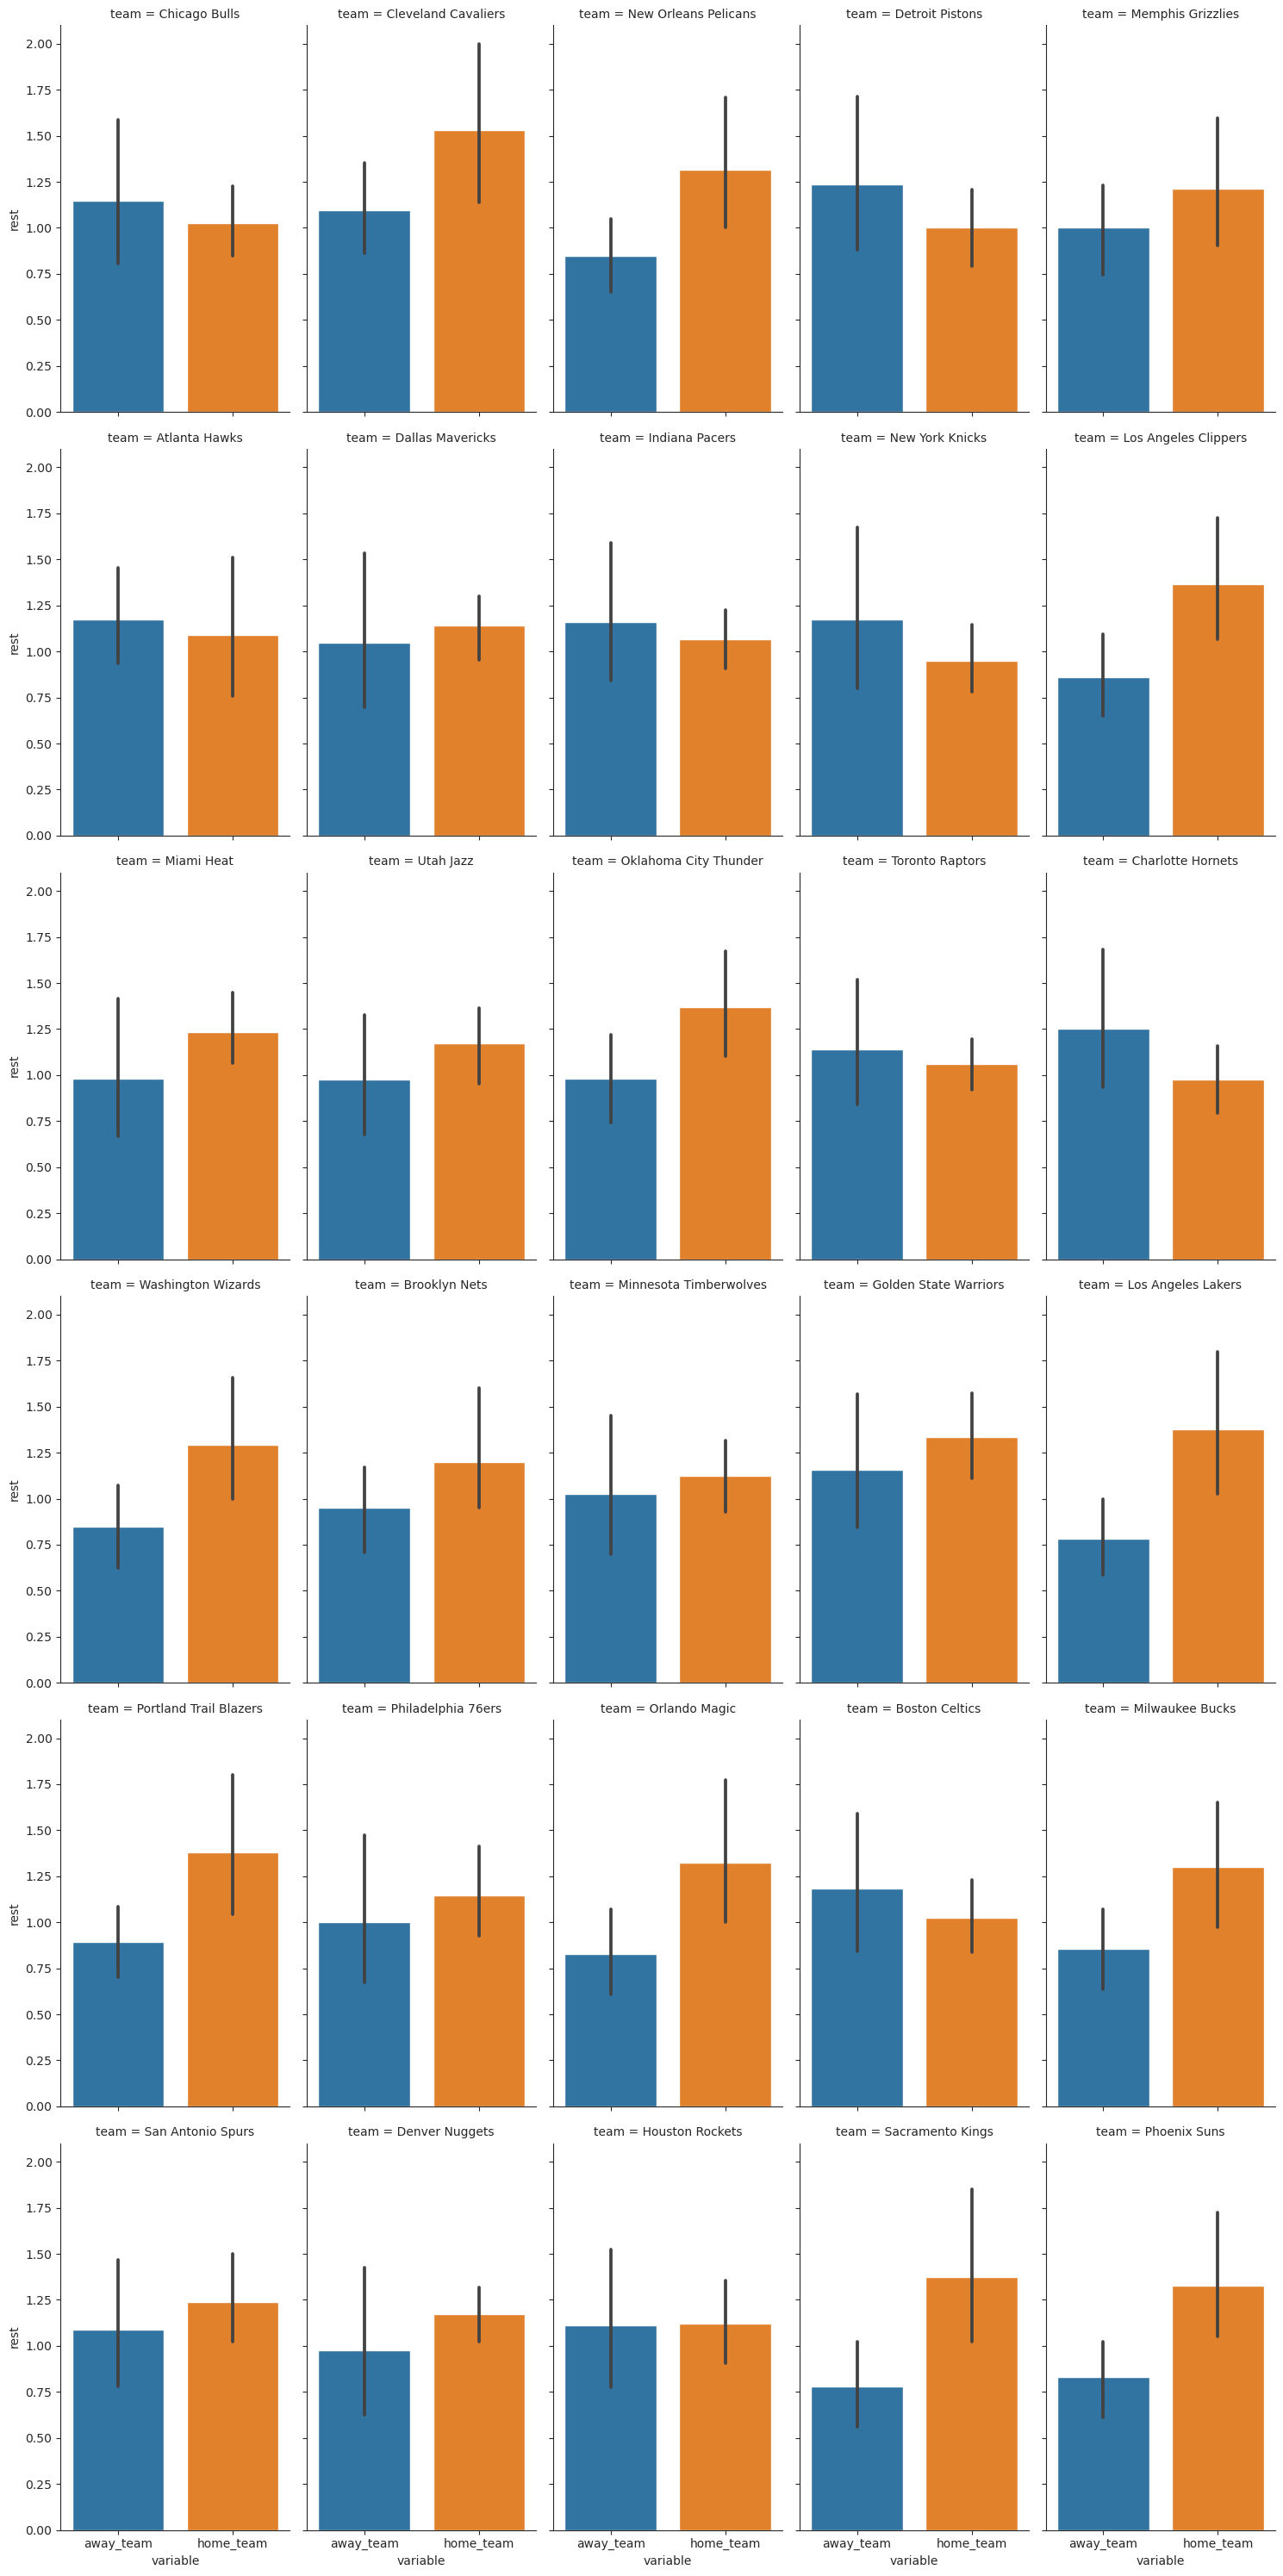

In [24]:
sns.catplot(
    tidy_pl.to_pandas(),
    x="variable",
    y="rest",
    col="team",
    col_wrap=5,
    kind="bar",
    aspect=0.6,
)


[Text(0.5, 0, 'Difference in Rest (Home - Away)'), Text(0, 0.5, 'Games')]

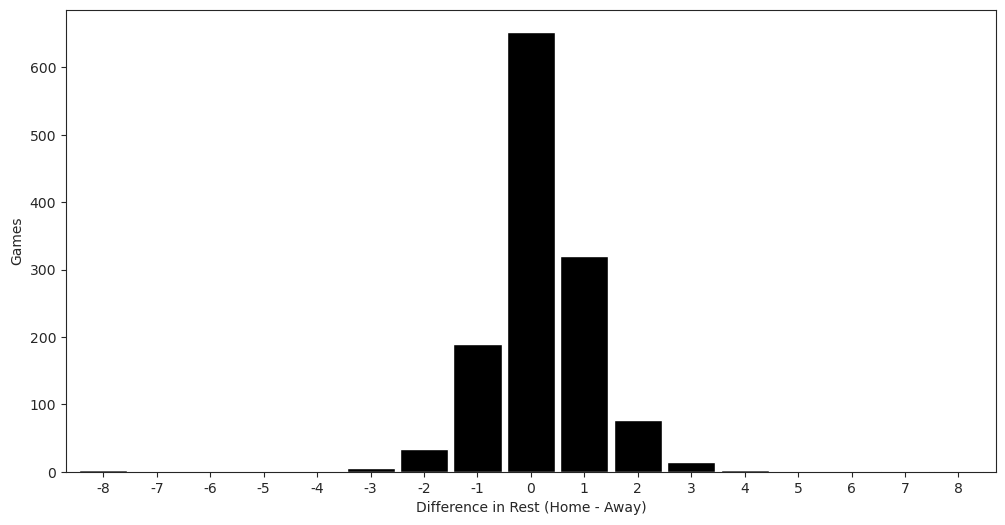

In [25]:
delta = joined_pl["rest_spread"]
ax = (
    delta.to_pandas()
    .value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind="bar", color="k", width=0.9, rot=0, figsize=(12, 6))
)
ax.set(xlabel="Difference in Rest (Home - Away)", ylabel="Games")


<AxesSubplot: xlabel='rest_spread', ylabel='home_win'>

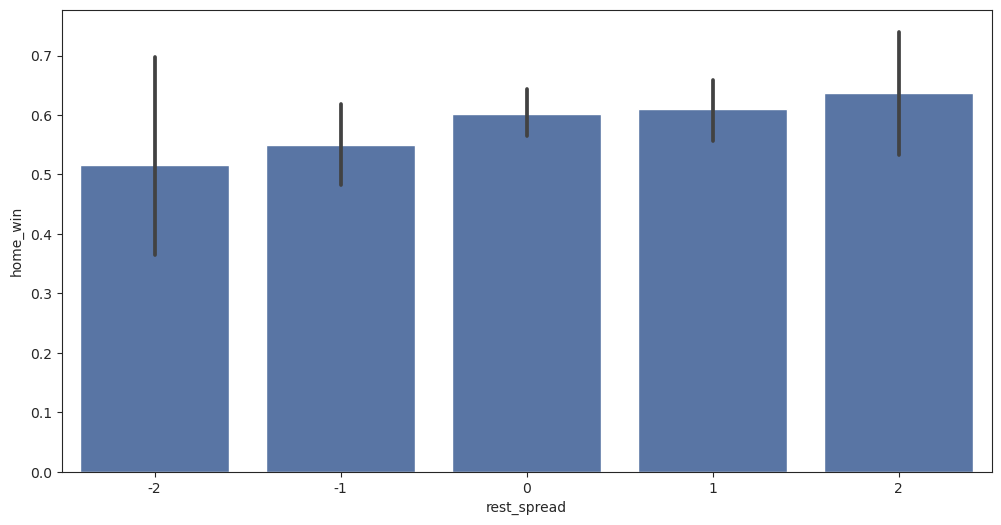

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x="rest_spread",
    y="home_win",
    data=joined_pl.filter(pl.col("rest_spread").is_between(-3, 3)).to_pandas(),
    color="#4c72b0",
    ax=ax,
)


In [27]:
rest_pl = tidy_pl.groupby(["date", "variable"]).agg(pl.col("rest").mean())


[Text(0, 0.5, 'Rest (7 day MA)')]

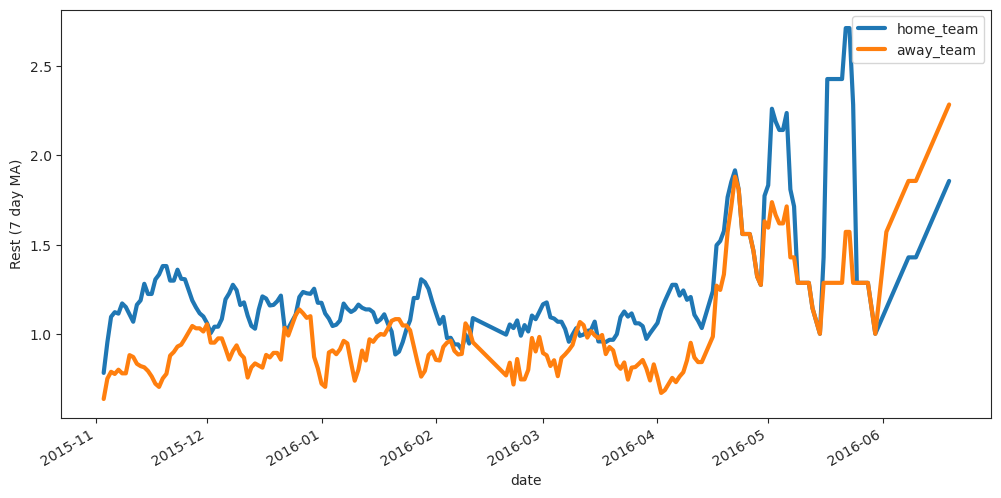

In [28]:
ax = (
    rest_pl.pivot(index="date", values="rest", columns="variable")
    .filter(pl.col("away_team") < 7)
    .sort("date")
    .select([pl.col("date"), pl.col(pl.Float64).rolling_mean(7)])
    .to_pandas()
    .set_index("date")
    .plot(figsize=(12, 6), linewidth=3)
)
ax.set(ylabel="Rest (7 day MA)")


In [29]:
win_col = pl.col("win")
wins = (
    joined_pl.melt(
        id_vars=["game_id", "date", "home_win"],
        value_name="team",
        variable_name="is_home",
        value_vars=["home_team", "away_team"],
    )
    .with_column(pl.col("home_win").alias("win") == (pl.col("is_home") == "home_team"))
    .groupby(["team", "is_home"])
    .agg(
        [
            win_col.sum().alias("n_wins"),
            win_col.count().alias("n_games"),
            win_col.mean().alias("win_pct"),
        ]
    )
)
wins.head()


team,is_home,n_wins,n_games,win_pct
str,str,u32,u32,f64
"""Golden State W...","""home_team""",49,54,0.907407
"""Los Angeles La...","""away_team""",5,41,0.121951
"""Oklahoma City ...","""home_team""",37,49,0.755102
"""Utah Jazz""","""away_team""",16,41,0.390244
"""Indiana Pacers...","""away_team""",20,44,0.454545


/home/user/mambaforge/envs/modern-polars/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


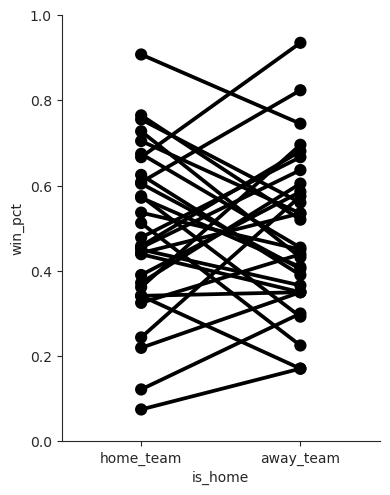

In [30]:
g = sns.FacetGrid(wins.to_pandas(), hue="team", aspect=0.8, palette=["k"], height=5)
g.map(sns.pointplot, "is_home", "win_pct").set(ylim=(0, 1))


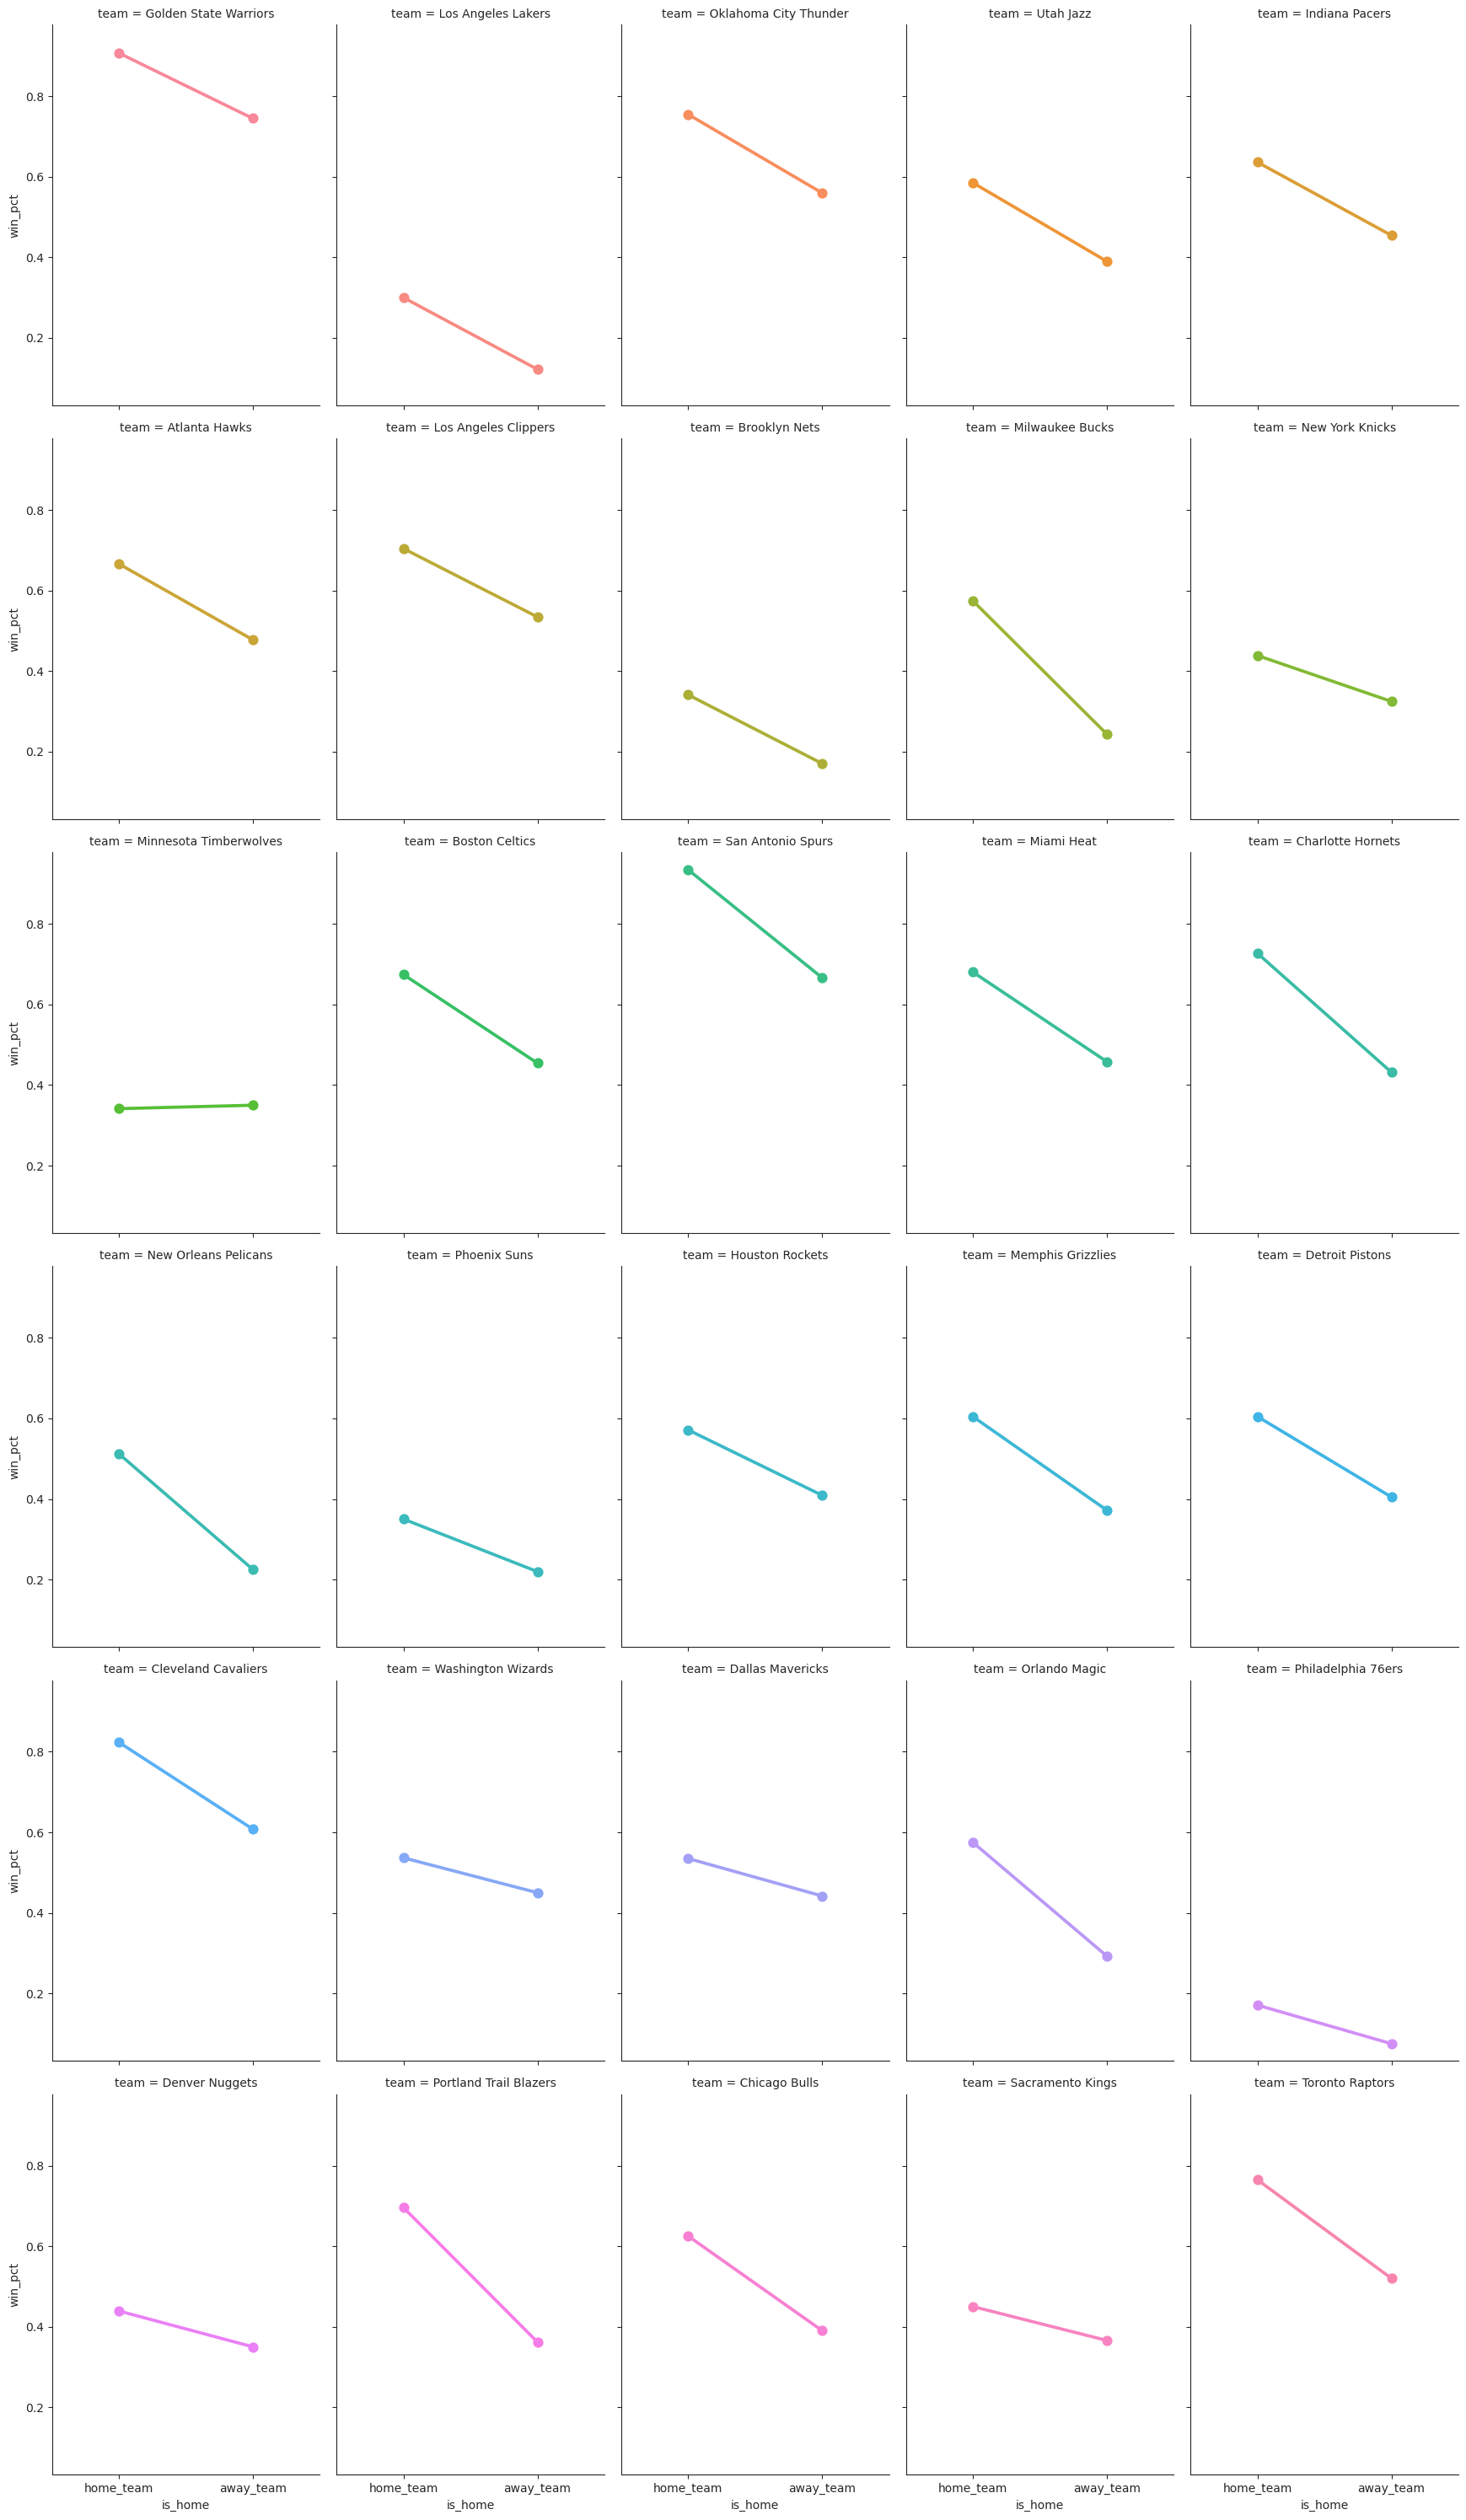

In [31]:
sns.catplot(
    wins.to_pandas(),
    x="is_home",
    y="win_pct",
    col="team",
    col_wrap=5,
    hue="team",
    kind="point",
    aspect=0.7,
)


In [32]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby("team").agg(
        pl.col("n_wins").sum().alias("win_pct") / pl.col("n_games").sum()
    )
)
win_percent.head()


team,win_pct
str,f64
"""Golden State W...",0.828571
"""Oklahoma City ...",0.656566
"""Denver Nuggets...",0.395062
"""Detroit Piston...",0.505882
"""Utah Jazz""",0.487805


Text(0.5, 102.72222222222219, 'Win Percent')

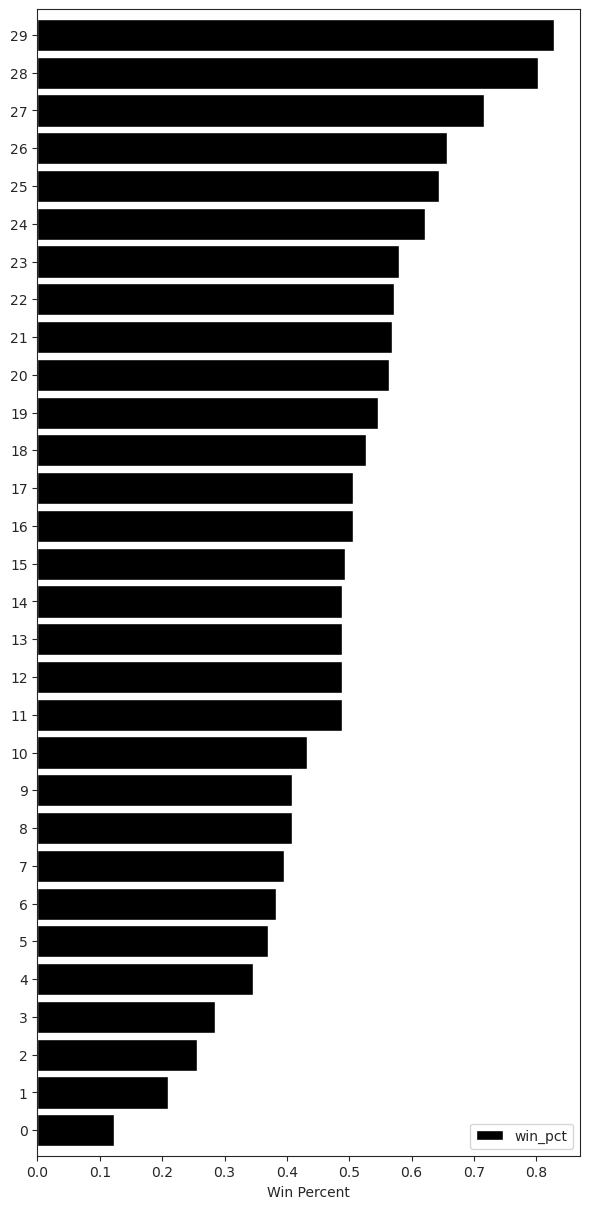

In [33]:
win_percent.sort("win_pct").to_pandas().plot.barh(
    figsize=(6, 12), width=0.85, color="k"
)
plt.tight_layout()
plt.xlabel("Win Percent")


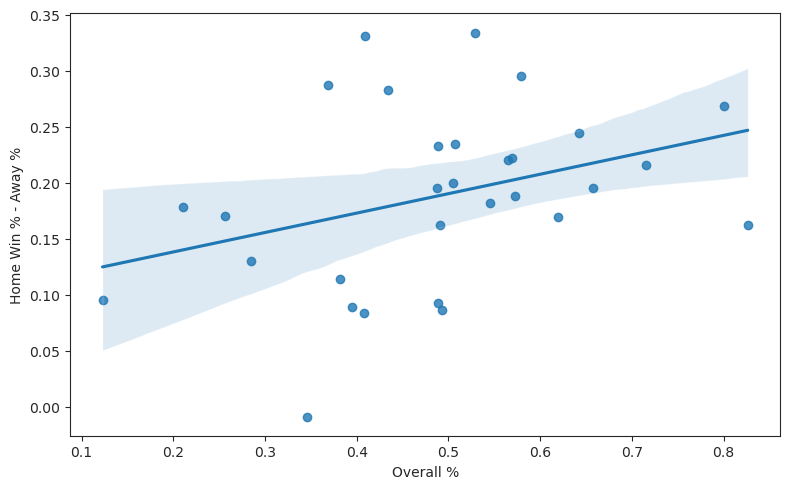

In [34]:
plt.figure(figsize=(8, 5))
(
    wins.pivot(index="team", columns="is_home", values="win_pct")
    .with_columns(
        [
            pl.col("home_team").alias("Home Win % - Away %") - pl.col("away_team"),
            (pl.col("home_team").alias("Overall %") + pl.col("away_team")) / 2,
        ]
    )
    .to_pandas()
    .pipe((sns.regplot, "data"), x="Overall %", y="Home Win % - Away %")
)
plt.tight_layout()


In [35]:
reg_df = (
    joined_pl.join(win_percent, left_on="home_team", right_on="team")
    .rename({"win_pct": "home_strength"})
    .join(win_percent, left_on="away_team", right_on="team")
    .rename({"win_pct": "away_strength"})
    .with_columns(
        [
            pl.col("home_points").alias("point_diff") - pl.col("away_points"),
            pl.col("home_rest").alias("rest_diff") - pl.col("away_rest"),
            pl.col("home_win").cast(pl.UInt8),  # for statsmodels
        ]
    )
)


In [26]:
import statsmodels.formula.api as sm

mod = sm.logit(
    "home_win ~ home_strength + away_strength + home_rest + away_rest",
    reg_df.to_pandas(),
)
res = mod.fit()
res.summary()


NameError: name 'reg_df' is not defined

# Time series

In [37]:
import requests
from io import StringIO


def epoch_ms(dt: datetime) -> int:
    return int(dt.timestamp()) * 1000


start = epoch_ms(datetime(2021, 1, 1))
end = epoch_ms(datetime(2022, 1, 1))


In [38]:
url = (
    "https://api.binance.com/api/v3/klines?symbol=BTCUSDT&"
    f"interval=1d&startTime={start}&endTime={end}"
)
resp = requests.get(url)


In [39]:
cols_to_use = [
    "time",
    "open",
    "high",
    "low",
    "close",
    "volume",
]
cols = cols_to_use + [f"ignore_{i}" for i in range(6)]
ohlcv = pl.from_records(resp.json(), orient="row", columns=cols).select(
    [
        pl.col("time").cast(pl.Datetime).dt.with_time_unit("ms").cast(pl.Date),
        pl.col(["open", "high", "low", "close", "volume"]).cast(pl.Float64),
    ]
)
ohlcv_pd = (
    pd.DataFrame.from_records(resp.json(), columns=cols)
    .assign(time=lambda df: pd.to_datetime(df["time"], unit="ms"))[cols_to_use]
    .set_index("time")
    .astype("float")
)


In [40]:
ohlcv_pd


,open,high,low,close,volume
time,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.925011
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362
...,...,...,...,...,...
2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.997960
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.463250


## Filtering

In [41]:
ohlcv.filter(pl.col("time").is_between(date(2021, 2, 1), date(2021, 3, 1))).head()


time,open,high,low,close,volume
date,f64,f64,f64,f64,f64
2021-02-02,33517.09,35984.33,33418.0,35466.24,78056.65988
2021-02-03,35472.71,37662.63,35362.38,37618.87,80784.333663
2021-02-04,37620.26,38708.27,36161.95,36936.66,92080.735898
2021-02-05,36936.65,38310.12,36570.0,38290.24,66681.334275
2021-02-06,38289.32,40955.51,38215.94,39186.94,98757.311183


### Downsampling

In [42]:
ohlcv.groupby_dynamic("time", every="5d").agg(pl.col(pl.Float64).mean()).head()


time,open,high,low,close,volume
date,f64,f64,f64,f64,f64
2021-01-01,31084.316,33127.622,29512.818,32089.662,112416.84957
2021-01-06,38165.31,40396.842,35983.822,39004.538,118750.076685
2021-01-11,36825.226,38518.1,33288.046,36542.762,146166.703112
2021-01-16,36216.36,37307.528,34650.372,35962.916,81236.801666
2021-01-21,32721.534,34165.706,30624.232,32077.48,97809.662654


In [43]:
ohlcv.groupby_dynamic("time", every="1w").agg(
    [pl.col(pl.Float64).mean().suffix("_mean"), pl.col(pl.Float64).sum().suffix("_sum")]
).head()


time,open_mean,high_mean,low_mean,close_mean,volume_mean,open_sum,high_sum,low_sum,close_sum,volume_sum
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-01-01,32305.781429,34706.045714,31021.727143,33807.135714,117435.5928,226140.47,242942.32,217152.09,236649.95,822049.149598
2021-01-08,37869.797143,39646.105714,34623.334286,37827.52,135188.296617,265088.58,277522.74,242363.34,264792.64,946318.076319
2021-01-15,36527.891429,37412.2,33961.551429,35343.847143,94212.715129,255695.24,261885.4,237730.86,247406.93,659489.005903
2021-01-22,31888.547143,33498.811429,30424.478571,32248.007143,89649.935836,223219.83,234491.68,212971.35,225736.05,627549.550849
2021-01-29,34511.482857,36411.441429,33450.08,35022.314286,102728.42481,241580.38,254880.09,234150.56,245156.2,719098.973673


### Upsampling

In [44]:
ohlcv.upsample("time", every="6h")


time,open,high,low,close,volume
date,f64,f64,f64,f64,f64
2021-01-01,28923.63,29600.0,28624.57,29331.69,54182.925011
2021-01-01,null,null,null,null,null
2021-01-01,null,null,null,null,null
2021-01-01,null,null,null,null,null
2021-01-02,29331.7,33300.0,28946.53,32178.33,129993.873362
2021-01-02,null,null,null,null,null
2021-01-02,null,null,null,null,null
2021-01-02,null,null,null,null,null
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.56675


In [45]:
ohlcv_pd["close"]


time
2021-01-01    29331.69
2021-01-02    32178.33
                ...   
2021-12-31    46216.93
2022-01-01    47722.65
Name: close, Length: 366, dtype: float64

In [46]:
ohlcv_pd["close"].expanding().mean()


time
2021-01-01    29331.690000
2021-01-02    30755.010000
                  ...     
2021-12-31    47400.003041
2022-01-01    47400.884590
Name: close, Length: 366, dtype: float64

In [47]:
def add(curr, prev):
    return curr + prev


ohlcv.select(pl.col("close").cumsum() / (pl.col("close").cumcount() + 1))


close
f64
29331.69
30755.01
31503.356667
31624.695
32089.662
32869.611667
33807.135714
34654.095
35257.886667


Text(0, 0.5, 'Close ($)')

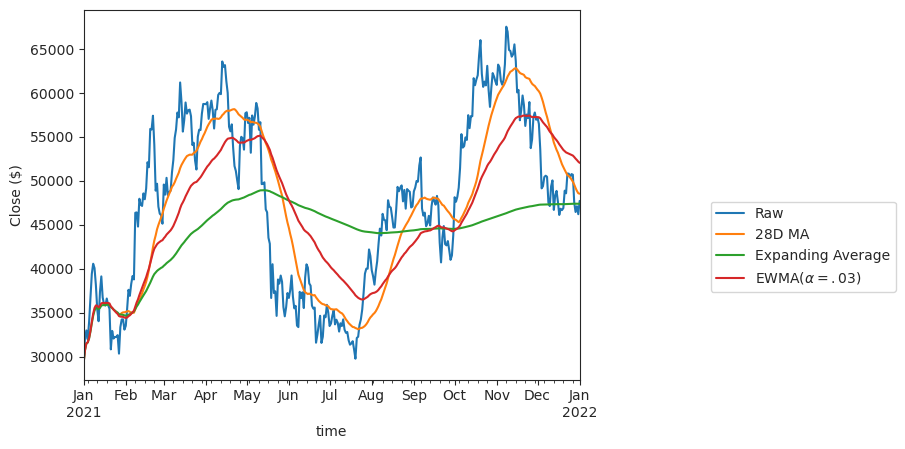

In [48]:
ohlcv_pd["close"].plot(label="Raw")
ohlcv_pd["close"].rolling(28).mean().plot(label="28D MA")
ohlcv_pd["close"].expanding().mean().plot(label="Expanding Average")
ohlcv_pd["close"].ewm(alpha=0.03).mean().plot(label="EWMA($\\alpha=.03$)")

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Close ($)")


Text(0, 0.5, 'Close ($)')

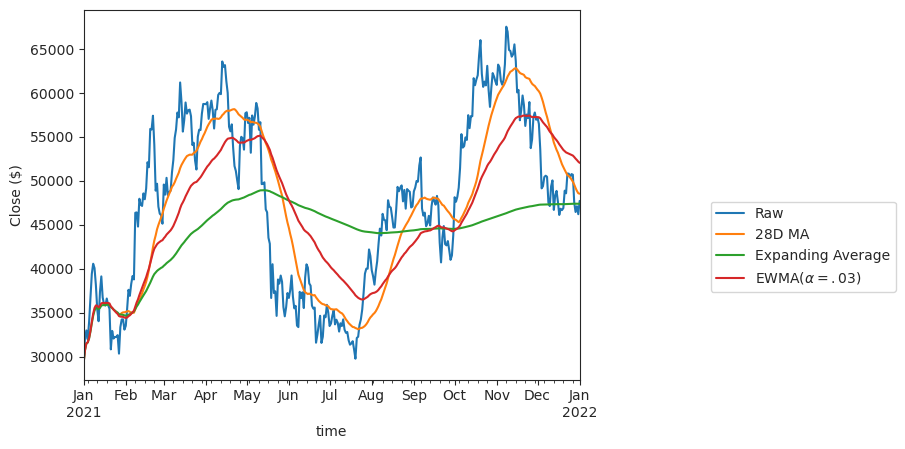

In [49]:
ohlcv.select(
    [
        pl.col("time"),
        pl.col("close").alias("Raw"),
        pl.col("close").rolling_mean(28).alias("28D MA"),
        pl.col("close").alias("Expanding Average").cumsum()
        / (pl.col("close").cumcount() + 1),
        pl.col("close").ewm_mean(alpha=0.03).alias("EWMA($\\alpha=.03$)"),
    ]
).to_pandas().set_index("time").plot()

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Close ($)")


Text(0, 0.5, 'Close ($)')

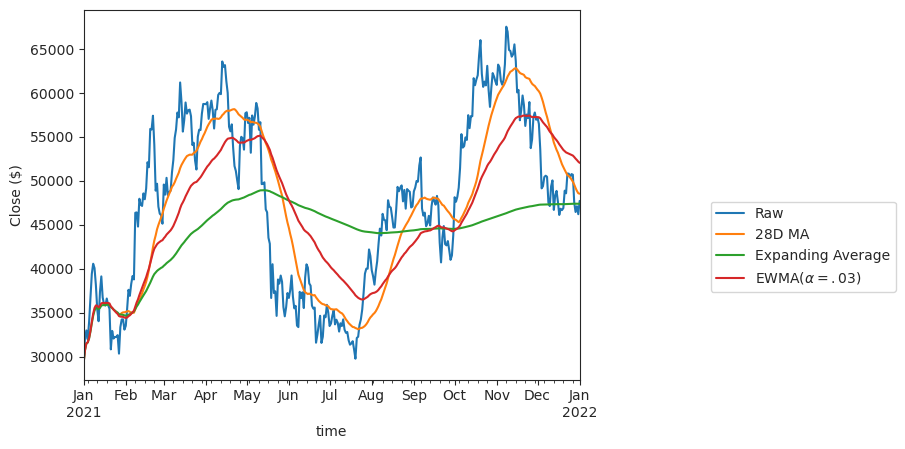

In [50]:
ohlcv_pd["close"].plot(label="Raw")
ohlcv_pd["close"].rolling(28).mean().plot(label="28D MA")
ohlcv_pd["close"].expanding().mean().plot(label="Expanding Average")
ohlcv_pd["close"].ewm(alpha=0.03).mean().plot(label="EWMA($\\alpha=.03$)")

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Close ($)")


Text(20.347222222222214, 0.5, 'Close ($)')

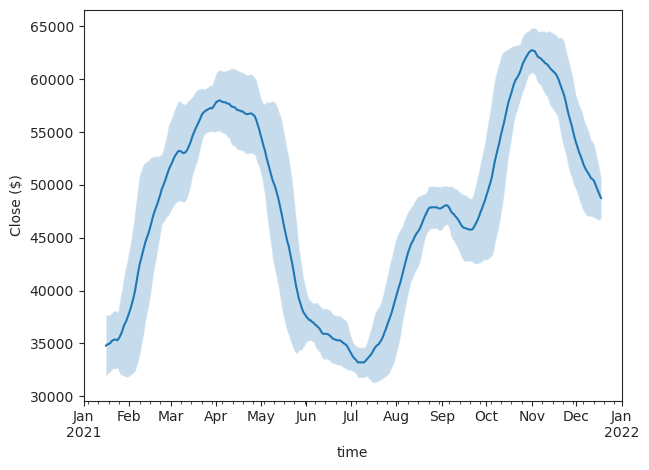

In [51]:
roll_pd = ohlcv_pd["close"].rolling(30, center=True)
mean_std_pd = roll_pd.agg(["mean", "std"])
ax = mean_std_pd["mean"].plot()
ax.fill_between(
    mean_std_pd.index,
    mean_std_pd["mean"] - mean_std_pd["std"],
    mean_std_pd["mean"] + mean_std_pd["std"],
    alpha=0.25,
)
plt.tight_layout()
plt.ylabel("Close ($)")


Text(20.347222222222214, 0.5, 'Close ($)')

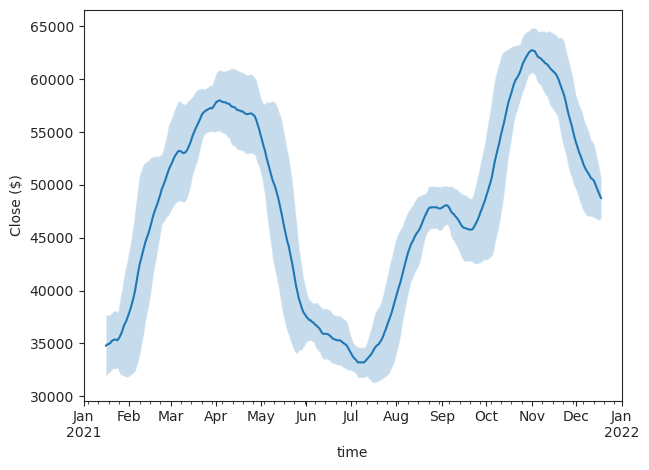

In [52]:
mean_std_pl = ohlcv.select(
    [
        "time",
        pl.col("close").rolling_mean(30, center=True).alias("mean"),
        pl.col("close").rolling_std(30, center=True).alias("std"),
    ]
)
ax = mean_std_pl.to_pandas().set_index("time")["mean"].plot()
ax.fill_between(
    mean_std_pl["time"].to_numpy(),
    mean_std_pl["mean"] - mean_std_pl["std"],
    mean_std_pl["mean"] + mean_std_pl["std"],
    alpha=0.25,
)
plt.tight_layout()
plt.ylabel("Close ($)")


## Grab Bag

### Offsets

Note: month offsets are ambiguous so don't use them in pandas

In [53]:
ohlcv.select(pl.col("time") + pl.duration(days=80)).head()


time
date
2021-03-22
2021-03-23
2021-03-24
2021-03-25
2021-03-26


### Holidays

Not supported in Polars yet. See [open issue](https://github.com/pola-rs/polars/issues/5713).

### Timezones

This basically says, "assume these times are UTC, now tell me what time it was in US/Eastern

In [54]:
ohlcv.select(pl.col("time").cast(pl.Datetime).dt.with_time_zone("US/Eastern")).head()


time
"datetime[μs, US/Eastern]"
2020-12-31 19:00:00 EST
2021-01-01 19:00:00 EST
2021-01-02 19:00:00 EST
2021-01-03 19:00:00 EST
2021-01-04 19:00:00 EST


In [2]:
fec_dir = Path("data/fec")

In [66]:
# data from https://www.fec.gov/data/browse-data/?tab=bulk-data
years = ['08', '10', '12', '14', '16']

cm_header = pd.read_csv("data/fec/cm_header_file.csv").columns
cm_cols = ['CMTE_ID', 'CMTE_NM', 'CMTE_PTY_AFFILIATION']
dtypes = {"CMTE_PTY_AFFILIATION": pl.Categorical}
for year in years:
    with zipfile.ZipFile(fec_dir / f"cm{year}.zip") as z:
        pl.read_csv(
            z.read("cm.txt"),
            has_header=False,
            columns=[0, 1, 10],
            new_columns=cm_cols,
            sep="|",
            dtypes=dtypes
        ).write_parquet(fec_dir / f"cm{year}.pq")

In [62]:
indiv_header = pd.read_csv("data/fec/indiv_header_file.csv").columns
dtypes = {
    "CMTE_ID": pl.Utf8,
    "EMPLOYER": pl.Categorical,
    "OCCUPATION": pl.Categorical,
    "TRANSACTION_DT": pl.Utf8, 
    "TRANSACTION_AMT": pl.Int32,
}
for year in years:
    with zipfile.ZipFile(fec_dir / f"indiv{year}.zip") as z:
        pl.read_csv(
            z.read("itcont.txt"),
            has_header=False,
            columns=[0, 11, 12, 13, 14],
            new_columns=list(dtypes.keys()),
            sep="|",
            dtypes=dtypes,
            encoding="cp1252",
        ).with_column(
            pl.col("TRANSACTION_DT").str.strptime(pl.Date, fmt="%m%d%Y", strict=False)
        ).write_parquet(fec_dir / f"indiv{year}.pq")

In [3]:
import dask.dataframe as dd
from dask import compute

In [6]:
files = sorted(fec_dir.glob("indiv*.pq"))

total_counts_pd = pd.Series(dtype="int64")

for year in files:
    occ_pd = pd.read_parquet(year, columns=['OCCUPATION'],
                         engine="pyarrow")
    counts = occ_pd["OCCUPATION"].value_counts()
    total_counts_pd = total_counts_pd.add(counts, fill_value=0).astype("int64")

total_counts_pd = total_counts_pd.nlargest(100).sort_values(ascending=False)

In [7]:
occ_dd = dd.read_parquet(fec_dir / "indiv*.pq", engine='pyarrow', columns=['OCCUPATION'])

most_common_dd = occ_dd["OCCUPATION"].value_counts().nlargest(100)
most_common_dd.compute().sort_values(ascending=False)

RETIRED         4773715
NOT EMPLOYED    2715939
                 ...   
SURGEON           25545
OPERATOR          25161
Name: OCCUPATION, Length: 100, dtype: int64

In [8]:
pl.toggle_string_cache(True)  # otherwise we can't read categoricals from multiple files
occ_pl = pl.scan_parquet(fec_dir / "indiv*.pq")
(
    occ_pl
    .select(
        pl.col("OCCUPATION")
        .value_counts(multithreaded=True, sort=True)
    )
    .head(100)
    .collect()
)

OCCUPATION
struct[2]
"{""BUSINESS DEVELOPER IV"",4773715}"
"{""DIRECTOR IT CUSTOMER SERVICE"",2715939}"
"{null,1439867}"
"{""MANAGER"",1339919}"
"{""OPERATIONS MANAGER IV"",660786}"
"{""OWNER"",494619}"
"{""BUSINESS DEVELOPER III"",477618}"
"{""EXECUTIVE VICE PRESIDENT"",361203}"
"{""NEPHROLOGIST"",357771}"


In [4]:
indiv_dd = (
    dd.read_parquet(fec_dir / "indiv*.pq", engine="pyarrow")
    # pandas and dask want datetimes but this is a date col
    .assign(TRANSACTION_DT=lambda df: dd.to_datetime(df["TRANSACTION_DT"], errors="coerce"))
)
avg_transaction_dd = indiv_dd["TRANSACTION_AMT"].mean()
total_by_employee_dd = (
    indiv_dd.groupby('EMPLOYER')
        ["TRANSACTION_AMT"].sum()
        .nlargest(10)
)
avg_by_occupation_dd = (
    indiv_dd.groupby("OCCUPATION")
        ["TRANSACTION_AMT"].mean()
        .nlargest(10)
)
computed_dd = compute(
    avg_transaction_dd, total_by_employee_dd, avg_by_occupation_dd
)

In [5]:
computed_dd[1]

EMPLOYER
RETIRED          1023306104
SELF-EMPLOYED     834757599
                    ...    
FAHR, LLC         166679844
CANDIDATE          75187243
Name: TRANSACTION_AMT, Length: 10, dtype: int32

In [6]:
indiv_pl = pl.scan_parquet(fec_dir / "indiv*.pq")
avg_transaction_pl = indiv_pl.select(pl.col("TRANSACTION_AMT").mean())
total_by_employee_pl = (
    indiv_pl
    .drop_nulls("EMPLOYER")
    .groupby('EMPLOYER')
    .agg([pl.col("TRANSACTION_AMT").sum()])
    .sort("TRANSACTION_AMT", reverse=True)
    .head(10)
)
avg_by_occupation_pl = (
    indiv_pl
    .groupby('OCCUPATION')
    .agg([pl.col("TRANSACTION_AMT").mean()])
    .sort("TRANSACTION_AMT", reverse=True)
    .head(10)
)
computed_pl = pl.collect_all(
    [
        # avg_transaction_pl,
        total_by_employee_pl,
        avg_by_occupation_pl
    ],
    streaming=True,
    common_subplan_elimination=False
)

thread '<unnamed>' panicked at 'should not fail: ComputeError(Borrowed("Cannot concat Categoricals coming from a different source. Consider setting a global StringCache."))', /home/runner/work/polars/polars/polars/polars-core/src/frame/mod.rs:915:36
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
thread '<unnamed>' panicked at 'should not fail: ComputeError(Borrowed("Cannot concat Categoricals coming from a different source. Consider setting a global StringCache."))', /home/runner/work/polars/polars/polars/polars-core/src/frame/mod.rs:915:36


PanicException: should not fail: ComputeError(Borrowed("Cannot concat Categoricals coming from a different source. Consider setting a global StringCache."))

In [ ]:
top_occupations_dd = (
    indiv_dd["OCCUPATION"].value_counts()
        .nlargest(10).index
).compute()
top_occupations_dd

CategoricalIndex(['RETIRED', 'NOT EMPLOYED', 'ATTORNEY', 'PHYSICIAN',
                  'HOMEMAKER', 'PRESIDENT', 'PROFESSOR', 'CONSULTANT',
                  'EXECUTIVE', 'ENGINEER'],
                 categories=['PUBLIC RELATIONS CONSULTANT', 'PRESIDENT', 'PHYSICIAN', 'SENIOR EXECUTIVE', ..., 'INFORMATION TECHNOLOGY TECH', 'HANDRIS REALTY', 'ELCM', 'DISANTO PRIEST & CO.'], ordered=False, dtype='category')

In [ ]:
top_occupations_pl = (
    indiv_pl
    .select(
        pl.col("OCCUPATION")
        .drop_nulls()
        .value_counts(sort=True)
        .head(10)
        .struct.field("OCCUPATION")
    )
).collect().to_series()
top_occupations_pl

OCCUPATION
cat
"""RETIRED"""
"""NOT EMPLOYED"""
"""ATTORNEY"""
"""PHYSICIAN"""
"""HOMEMAKER"""
"""PRESIDENT"""
"""PROFESSOR"""
"""CONSULTANT"""
"""EXECUTIVE"""


In [ ]:
donations_dd = (
    indiv_dd[indiv_dd["OCCUPATION"].isin(top_occupations_dd)]
        .groupby("OCCUPATION")
        ["TRANSACTION_AMT"]
        .mean()
        .dropna()
)

In [ ]:
donations_pl = (
    indiv_pl
    .filter(pl.col("OCCUPATION").is_in(top_occupations_pl))
    .groupby("OCCUPATION")
    .agg(pl.col("TRANSACTION_AMT").mean())
)

In [ ]:
total_avg_dd, occupation_avg_dd = compute(indiv_dd["TRANSACTION_AMT"].mean(), donations_dd)

In [ ]:
averages_pl = pl.collect_all([indiv_pl.select(pl.col("TRANSACTION_AMT").mean()), donations_pl])
total_avg_pl = averages_pl[0][0, 0]
occupation_avg_pl = averages_pl[1]

PARTITIONED DS


[Text(0.5, 0, 'Donation Amount'),
 Text(0.5, 1.0, 'Average Dontation by Occupation')]

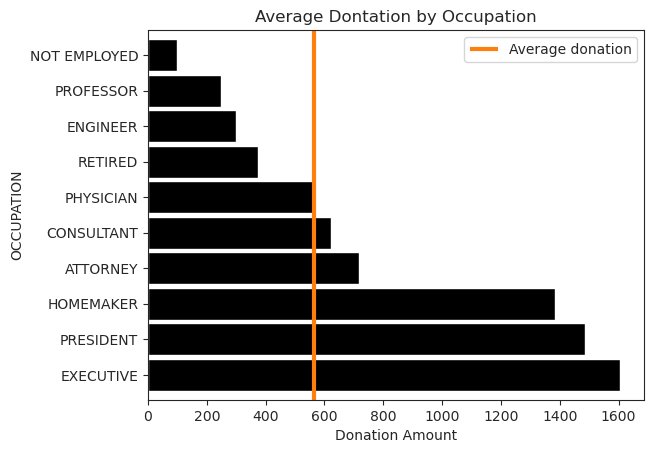

In [ ]:
ax = occupation_avg_dd.sort_values(ascending=False).plot.barh(color='k', width=0.9)
lim = ax.get_ylim()
ax.vlines(total_avg_dd, *lim, color='C1', linewidth=3)
ax.legend(['Average donation'])
ax.set(xlabel="Donation Amount", title="Average Dontation by Occupation")

[Text(0.5, 0, 'Donation Amount'),
 Text(0.5, 1.0, 'Average Dontation by Occupation')]

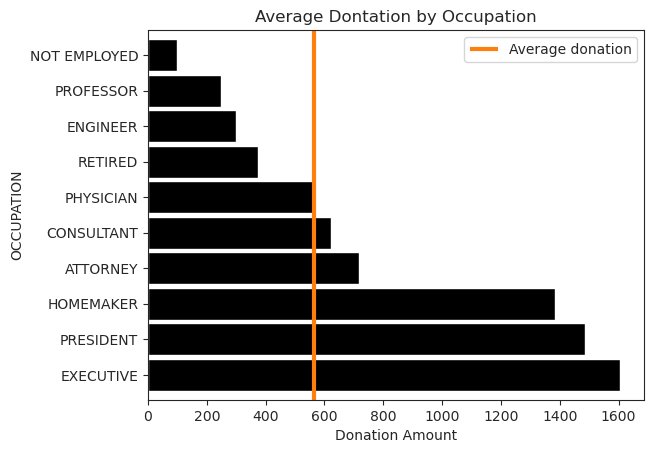

In [ ]:
ax = occupation_avg_pl.to_pandas().set_index("OCCUPATION").squeeze().sort_values(ascending=False).plot.barh(color='k', width=0.9)
lim = ax.get_ylim()
ax.vlines(total_avg_pl, *lim, color='C1', linewidth=3)
ax.legend(['Average donation'])
ax.set(xlabel="Donation Amount", title="Average Dontation by Occupation")

In [71]:
daily_dd = (
    indiv_dd[['TRANSACTION_DT', 'TRANSACTION_AMT']]
    .dropna()
    .set_index('TRANSACTION_DT')
    ['TRANSACTION_AMT']
    .resample("D")
    .sum()
).compute()
daily_dd

TRANSACTION_DT
1916-01-23    1000
1916-01-24       0
              ... 
2201-06-01       0
2201-06-02    2000
Freq: D, Name: TRANSACTION_AMT, Length: 104226, dtype: int32

In [72]:
daily_pl = (
    indiv_pl.select(['TRANSACTION_DT', 'TRANSACTION_AMT'])
    .drop_nulls()
    .sort("TRANSACTION_DT")
    .groupby_dynamic("TRANSACTION_DT", every="1d")
    .agg(pl.col("TRANSACTION_AMT").sum())
    .collect()
)
daily_pl

TRANSACTION_DT,TRANSACTION_AMT
date,i32
1015-10-05,2700
1015-10-19,200
1015-10-30,1000
1216-07-03,25
1916-01-23,1000
1931-04-23,1000
2000-01-13,2400
2000-01-31,150
2000-02-28,1000


[(0.0, 83407.5242),
 Text(0.5, 1.0, 'Daily Donations'),
 Text(0, 0.5, '$ (thousands)')]

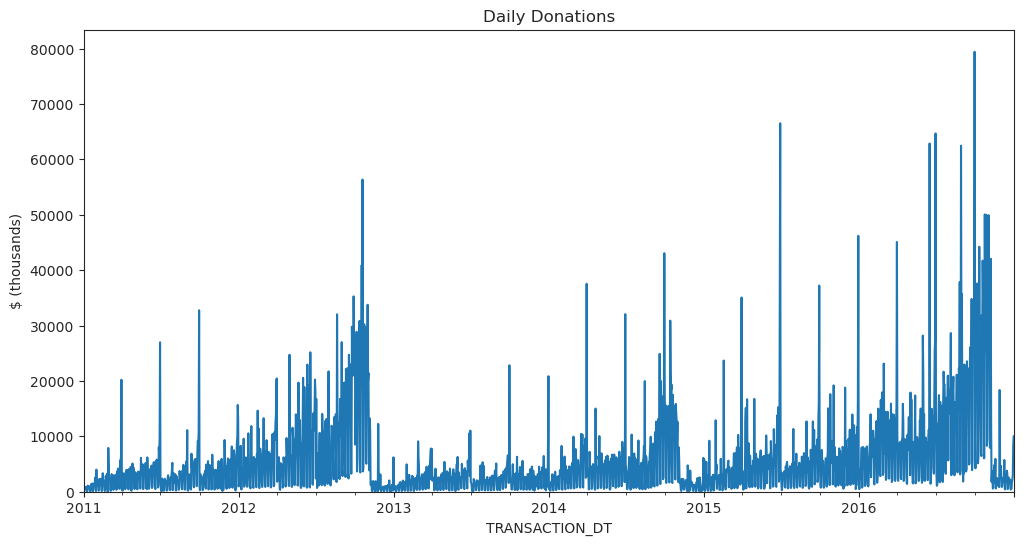

In [73]:
subset_dd = daily_dd.loc['2011':'2016']
ax = subset_dd.div(1000).plot(figsize=(12, 6))
ax.set(ylim=0, title="Daily Donations", ylabel="$ (thousands)")

[(0.0, 83407.5242),
 Text(0.5, 1.0, 'Daily Donations'),
 Text(0, 0.5, '$ (thousands)')]

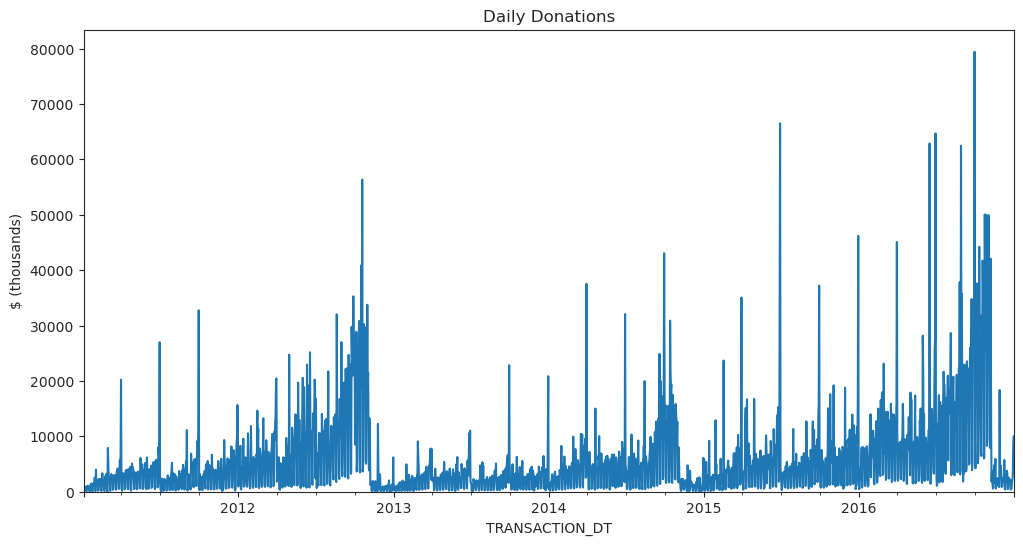

In [74]:
subset_pl = daily_pl.filter(pl.col("TRANSACTION_DT").is_between(date(2011, 1, 1), date(2017, 1, 1)))
ax = (
    subset_pl
    .select([
        pl.col("TRANSACTION_DT").cast(pl.Datetime),
        pl.col("TRANSACTION_AMT") / 1000
    ])
    .to_pandas()
    .set_index("TRANSACTION_DT")
    .squeeze()
    .plot(figsize=(12, 6)))
ax.set(ylim=0, title="Daily Donations", ylabel="$ (thousands)")

In [75]:
cm_dd = (
    # This data is small but we use dask here as a convenient way to read a glob of files.
    dd.read_parquet(fec_dir / "cm*.pq")
    .compute()
    # Some committees change their name, but the ID stays the same
    # If we use .last instead of .nth(-1), we get the last non-null value
    .groupby('CMTE_ID', as_index=False).nth(-1)
)
cm_dd

,CMTE_ID,CMTE_NM,CMTE_PTY_AFFILIATION
7,C00000794,LENT & SCRIVNER PAC,UNK
15,C00001156,MICHIGAN LEAGUE OF COMMUNITY BANKS POLITICAL A...,NaN
...,...,...,...
17649,C99002396,AMERICAN POLITICAL ACTION COMMITTEE,NaN
17650,C99003428,THIRD DISTRICT REPUBLICAN PARTY,REP


In [76]:
pl.toggle_string_cache(True)
cm_pl = (
    # This data is small so we don't use streaming.
    pl.read_parquet(fec_dir / "cm*.pq")
    # Some committees change their name, but the ID stays the same
    .groupby('CMTE_ID', maintain_order=True).last()
)
cm_pl

CMTE_ID,CMTE_NM,CMTE_PTY_AFFILIATION
str,str,cat
"""C00000042""","""ILLINOIS TOOL ...",null
"""C00000059""","""HALLMARK CARDS...","""UNK"""
"""C00000422""","""AMERICAN MEDIC...",null
"""C00000489""","""D R I V E POLI...",null
"""C00000547""","""KANSAS MEDICAL...","""UNK"""
"""C00000638""","""INDIANA STATE ...",null
"""C00000729""","""AMERICAN DENTA...","""UNK"""
"""C00000794""","""LENT & SCRIVN...","""UNK"""
"""C00000885""","""INTERNATIONAL ...","""UNK"""


In [84]:
indiv_filtered_dd = (
    indiv_dd[
        (indiv_dd["TRANSACTION_DT"] >= pd.Timestamp("2007-01-01")) 
        & (indiv_dd["TRANSACTION_DT"] <= pd.Timestamp("2017-01-01"))
    ]
)

merged_dd = dd.merge(indiv_filtered_dd, cm_dd, on='CMTE_ID')

In [83]:
indiv_filtered_pl = indiv_pl.filter(
    pl.col("TRANSACTION_DT")
    .is_between(date(2007, 1, 1), date(2017, 1, 1), include_bounds=True)
)

merged_pl = indiv_filtered_pl.join(cm_pl.lazy(), on='CMTE_ID')

In [79]:
party_donations_dd = (
    merged_dd
    .groupby(["TRANSACTION_DT", "CMTE_PTY_AFFILIATION"])
    ["TRANSACTION_AMT"].sum()
).compute().sort_index()

In [80]:
party_donations_pl = (
    merged_pl
    .groupby(["TRANSACTION_DT", "CMTE_PTY_AFFILIATION"])
    .agg(pl.col("TRANSACTION_AMT").sum())
    .sort(["TRANSACTION_DT", "CMTE_PTY_AFFILIATION"])
    .collect()
)

PARTITIONED DS


[Text(0.5, 1.0, 'Daily Donations (30-D Moving Average)'), Text(0.5, 0, 'Date')]

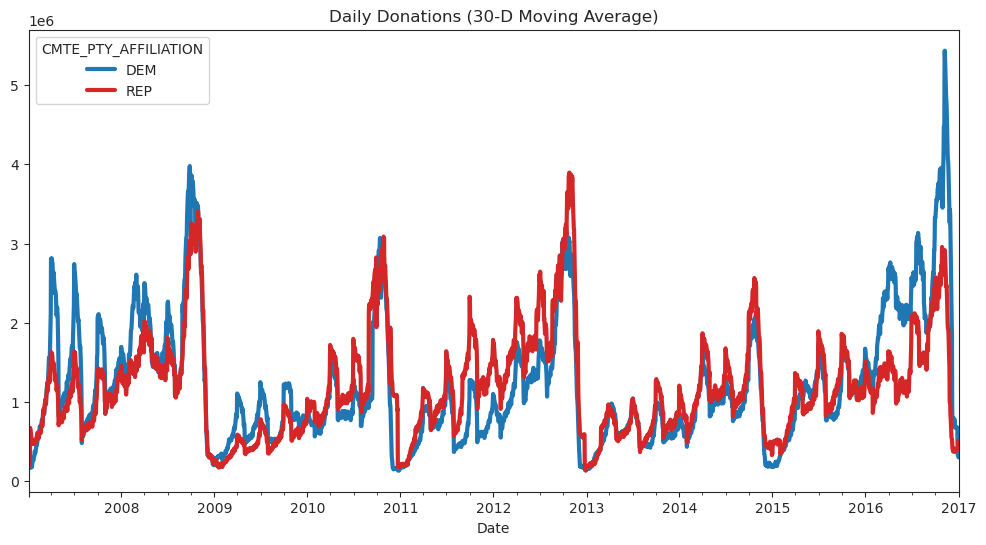

In [81]:
ax = (
    party_donations_dd
    .loc[:, ['REP', 'DEM']]
    .unstack("CMTE_PTY_AFFILIATION")
    .iloc[1:]
    .rolling('30D')
    .mean()
    [["DEM", "REP"]]
    .plot(color=['C0', 'C3'], figsize=(12, 6), linewidth=3)
)
ax.set(title="Daily Donations (30-D Moving Average)", xlabel="Date")

[Text(0.5, 1.0, 'Daily Donations (30-D Moving Average)'), Text(0.5, 0, 'Date')]

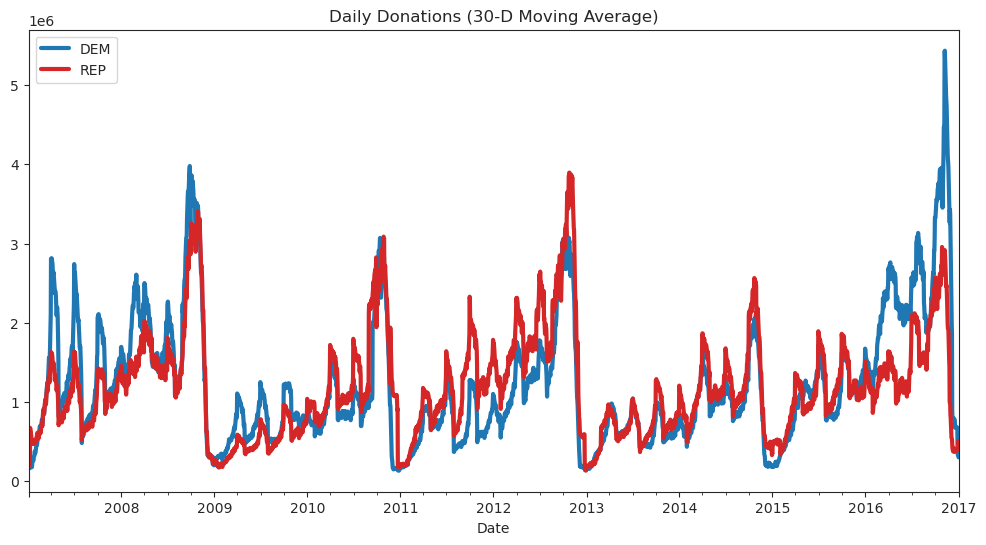

In [82]:
ax = (
    party_donations_pl
    .filter(pl.col("CMTE_PTY_AFFILIATION").is_in(["DEM", "REP"]))
    .pivot(index="TRANSACTION_DT", columns="CMTE_PTY_AFFILIATION", values="TRANSACTION_AMT")
    [1:, :]
    .select([pl.col("TRANSACTION_DT"), pl.col(pl.Int32).rolling_mean(30, min_periods=0)])
    .to_pandas()
    .set_index("TRANSACTION_DT")
    [["DEM", "REP"]]
    .plot(color=['C0', 'C3'], figsize=(12, 6), linewidth=3)
)
ax.set(title="Daily Donations (30-D Moving Average)", xlabel="Date")